In [3]:
import torch
import torch.nn as nn
import pandas
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(10)
dtype = torch.FloatTensor

In [4]:
def generate_real():
    real_data = torch.FloatTensor(
            [np.random.uniform(0.8, 1.0),
            np.random.uniform(0.0, 0.2),
            np.random.uniform(0.8, 1.0),
            np.random.uniform(0.0, 0.2)])     # CPU上32位浮点型
    return real_data

def generate_random(size=4):
        random_data = torch.rand(size)
        return random_data

# 鉴别器

In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
                        nn.Linear(4, 3),
                        nn.Sigmoid(),
                        nn.Linear(3, 1),
                        nn.Sigmoid()
        )

        # 创建损失函数
        self.loss_function = nn.MSELoss()

        # 创建优化器, 使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), 
                                            lr=0.01)
        
        # 计数器和进程记录
        self.counter = 0
        self.progress = []
                
    def forward(self,inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.model(inputs)
        
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        
        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        if (self.counter % 10000 == 0): print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1

        pass
    
    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Discriminator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()
        pass

counter =  0
counter =  10000
counter =  20000
counter =  30000


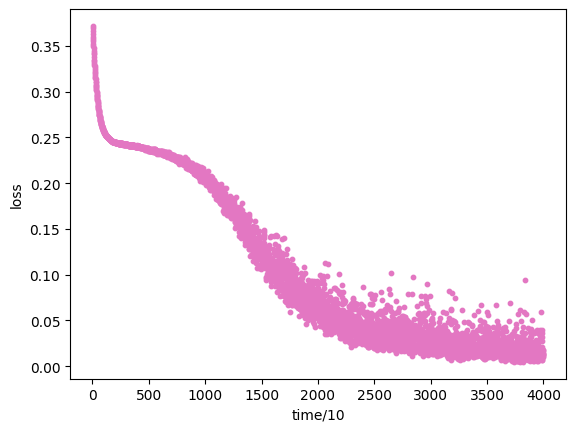

CPU times: total: 13.5 s
Wall time: 13.7 s


4000

In [35]:
%%time

# 查看鉴别器
D = Discriminator()
for i in range(20000):
    # 正确值
    D.train(generate_real(), torch.FloatTensor([1.0]))
        
    # 错误值
    D.train(generate_random(), torch.FloatTensor([0.0]))

D.plot_progress()
         
len(D.progress)  


In [41]:
D.forward(torch.FloatTensor([0.9,0.1,0.99,0.02]))

tensor([0.9128], grad_fn=<SigmoidBackward0>)

# 生成器

In [42]:
class Generator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
                    nn.Linear(1, 3),
                    nn.Sigmoid(),
                    nn.Linear(3, 4),
                    nn.Sigmoid()
        )

        # 创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), 
                                            lr=0.01)
        
        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入鉴别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)

        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1
    
    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Generator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()
        pass

In [43]:
# 创建生成器和鉴别器
D = Discriminator()
G = Generator()

# 训练
for i in range(20000):
    # 正确值
    D.train(generate_real(), torch.FloatTensor([1.0]))

    # 用生成器生成的数据训练鉴别器（错误 0.0）
    D.train(G.forward(torch.FloatTensor([1.0])).detach(), torch.FloatTensor([0.0]))

    # 用生成器生成的数据训练生成器(错误 1.0）
    G.train(D, torch.FloatTensor([1.0]), torch.FloatTensor([1.0]))
    
    pass
